In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import model_based_agent as mba 
import worm_env as we 
import fake_worm as fw
import ensemble_mod_env as eme

from improc import *
import utils as ut
import tab_agents as tab
from datetime import datetime 

In [9]:
detpol = np.zeros((12,12))+1
detpol[:6,:6] = -1
detpol[6:,6:] = -1

def pol_test(mod,folder,sets,
            rand_ep_time = 120,
            eval_ep_time = 120,
            worm_ep_len = 120):
    # Takes a model with reward_on as the policy (>0 light on; <0 light off) and 
    # reward_off as zeros. Runs a random episode followed by an evaluation episode {sets} times.
    # Saves every episode trajectory as rand{i}.pkl or eval{i}.pkl (dicts).
    # Returns rands (list) and evals (list) of reward vectors.
    
    if os.path.isdir(folder):
        raise ValueError('Folder already exists.')
    os.mkdir(folder)
    
    rands,evals,dets = [],[],[]
    worm = fw.FakeWorm(0,ep_len=worm_ep_len)
    cam,task = init_instruments()
    
    # Random policy
    cp = mod['reward_on'][:,:,0].copy().flatten() 
    np.random.shuffle(cp)
    ant_rand = tab.Q_Alpha_Agent() 
    ant_rand.Qtab = np.zeros(ant_rand.Qtab.shape)
    ant_rand.Qtab[:,1] = cp
    runner_rand = mba.WormRunner(ant_rand, worm, act_spacing=1)
    
    # Test policy
    ant_eval = tab.Q_Alpha_Agent() # Test policy
    ant_eval.Qtab = np.zeros(ant_eval.Qtab.shape)
    ant_eval.Qtab[:,1] = mod['reward_on'][:,:,0].flatten() 
    runner_eval = mba.WormRunner(ant_eval, worm, act_spacing=1)
    
    # Deterministic policy
    ant_det = tab.Q_Alpha_Agent()
    ant_det.Qtab = np.zeros(ant_det.Qtab.shape)
    ant_det.Qtab[:,1] = detpol.flatten()
    runner_det = mba.WormRunner(ant_det, worm, act_spacing=1)
    
    
    for s in range(sets):
        fname_r = folder+f'rand{s}.pkl'
        fname_e = folder+f'eval{s}.pkl'
        fname_d = folder+f'det{s}.pkl'
        print(f'Running set {s}')
        
        dets.append(runner_det.eval_ep(cam,task,fname_d,eval_eps=rand_ep_time//worm_ep_len))
        print(np.mean(dets[s]))
        task.write(0)
        evals.append(runner_eval.eval_ep(cam,task,fname_e,eval_eps=eval_ep_time//worm_ep_len))
        print(np.mean(evals[s]))
        task.write(0)
        rands.append(runner_rand.eval_ep(cam,task,fname_r,eval_eps=rand_ep_time//worm_ep_len))
        print(np.mean(rands[s]))
        task.write(0)

    
    cam.exit()
    task.write(0)
    task.close()
    
    return rands,evals,dets,ant_rand,ant_eval,ant_det

def one_pol(mod,folder,name,n,worm_ep_len=120):
    # Takes a model with reward_on as the policy (>0 light on; <0 light off) and 
    # reward_off as zeros. Runs n episodes.
    # Saves every episode trajectory as name{i}.pkl (dicts).
    # Returns list of reward vectors.
    
    if os.path.isdir(folder):
        raise ValueError('Folder already exists.')
    os.mkdir(folder)
    
    rews = []
    worm = we.ProcessedWorm(0,ep_len=worm_ep_len)
    cam,task = init_instruments()
    
    # Test policy
    ant_eval = tab.Q_Alpha_Agent() # Test policy
    ant_eval.Qtab = np.zeros(ant_eval.Qtab.shape)
    ant_eval.Qtab[:,1] = mod['reward_on'][:,:,0].flatten() 
    runner_eval = mba.WormRunner(ant_eval, worm, act_spacing=1)
    
    for s in range(n):
        fname = folder+f'{name}{s}.pkl'
        print(f'Running set {s}')
        
        rews.append(runner_eval.eval_ep(cam,task,fname,eval_eps=1))
        print(np.mean(rews[s]))
        task.write(0)
    
    cam.exit()
    task.write(0)
    task.close()
    
    return rews

def get_model_from_files(files,lp_frac):
    dh = mba.DataHandler()
    dh.load_df(files[0]+'alls.pkl')
    for f in files[1:]:
        dh.add_df_to_df([f+'alls.pkl'])
    mset = eme.ModelSet(1,frac=1,lp_frac=lp_frac)
    mset.make_models(dh,sm_pars={'lambda':.1,'iters':10})
    return mset.models[0]

def plot_mods(models,vmin=None,vmax=None):
    fig,ax = plt.subplots(len(models),7)
    fig.set_size_inches((15,2*len(models)))
    for m,mod in enumerate(models):
        for i,(key,item) in enumerate(mod.items()):
            if i<4:
                img = ax[m,i].imshow(item[:,:,0],vmin=-180,vmax=180)
            else:
                img = ax[m,i].imshow(item[:,:,0],vmin=vmin,vmax=vmax)
            cbar = fig.colorbar(img,ax=ax[m,i])
            ax[m,i].axis('off')
            cbar.set_ticks([])
            if m==0:
                ax[m,i].set_title(f'{len(models)} models: {key}')
        ax[m,6].imshow(np.sign(mod['reward_on'][:,:,0]-mod['reward_off'][:,:,0]),vmin=-1,vmax=1)

In [17]:
# Fake worm policy testing to make sure eval is working as expected

detpol = np.zeros((12,12))+1
detpol[:6,:6] = -1
detpol[6:,6:] = -1

def pol_test(mod,folder,sets,
            rand_ep_time = 120,
            eval_ep_time = 120,
            worm_ep_len = 120):
    # Takes a model with reward_on as the policy (>0 light on; <0 light off) and 
    # reward_off as zeros. Runs a random episode followed by an evaluation episode {sets} times.
    # Saves every episode trajectory as rand{i}.pkl or eval{i}.pkl (dicts).
    # Returns rands (list) and evals (list) of reward vectors.
    
    if os.path.isdir(folder):
        raise ValueError('Folder already exists.')
    os.mkdir(folder)
    
    rands,evals,dets = [],[],[]
    worm = fw.FakeWorm(0,ep_len=worm_ep_len)
    
    # Random policy
    cp = mod['reward_on'][:,:,0].copy().flatten() 
    np.random.shuffle(cp)
    ant_rand = tab.Q_Alpha_Agent() 
    ant_rand.Qtab = np.zeros(ant_rand.Qtab.shape)
    ant_rand.Qtab[:,1] = cp
    runner_rand = mba.WormRunner(ant_rand, worm, act_spacing=1)
    
    # Test policy
    ant_eval = tab.Q_Alpha_Agent() # Test policy
    ant_eval.Qtab = np.zeros(ant_eval.Qtab.shape)
    ant_eval.Qtab[:,1] = mod['reward_on'][:,:,0].flatten() 
    runner_eval = mba.WormRunner(ant_eval, worm, act_spacing=1)
    
    # Deterministic policy
    ant_det = tab.Q_Alpha_Agent()
    ant_det.Qtab = np.zeros(ant_det.Qtab.shape)
    ant_det.Qtab[:,1] = detpol.flatten()
    runner_det = mba.WormRunner(ant_det, worm, act_spacing=1)
    
    
    for s in range(sets):
        fname_r = folder+f'rand{s}.pkl'
        fname_e = folder+f'eval{s}.pkl'
        fname_d = folder+f'det{s}.pkl'
        print(f'Running set {s}')
        
        dets.append(runner_det.eval_ep_fake(fname_d,eval_eps=rand_ep_time//worm_ep_len))
        print(np.mean(dets[s]))
        evals.append(runner_eval.eval_ep_fake(fname_e,eval_eps=eval_ep_time//worm_ep_len))
        print(np.mean(evals[s]))
        rands.append(runner_rand.eval_ep_fake(fname_r,eval_eps=rand_ep_time//worm_ep_len))
        print(np.mean(rands[s]))

    
    return rands,evals,dets,ant_rand,ant_eval,ant_det

In [7]:
folder = './Data/Det'+datetime.now().strftime('%d-%m-%H-%M')+'/'
files = ['./Data/HTFix19-01-18-47/',
           './Data/HTFix19-01-20-29/',
           './Data/HTFix19-01-21-18/',
           './Data/HTFix20-01-09-04/',
           './Data/HTFix20-01-09-42/',
           './Data/HTFix20-01-10-41/',
          ]
files = ['../01_13_reals/'+f[2:] for f in files]
mod = get_model_from_files(files,.4)
mod['reward_on'][:,:,0] = randpol#detpol #################

On model 0
Penalty 0.1781687902807265


In [6]:
randpol = np.random.randn(12,12)-.2
np.sum((np.sign(randpol)+1)/2)/144

0.4097222222222222

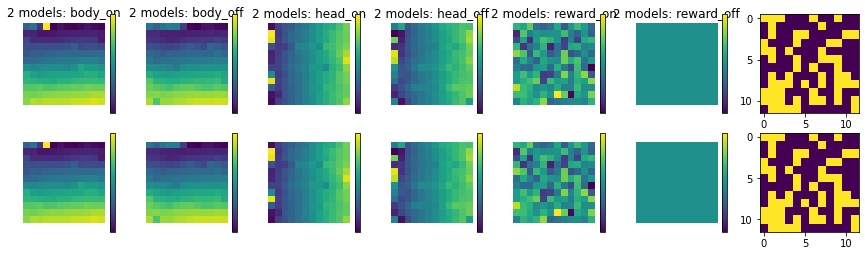

In [10]:
plot_mods([mod,mod])

# Deterministic policy

In [5]:
rands,evals,dets,ant_rand,ant_eval,ant_det = pol_test(mod,folder,2,           
            rand_ep_time = 1000,
            eval_ep_time = 1000,
            worm_ep_len = 1000)

ValueError: Folder already exists.

In [33]:
cam,task = init_instruments()
for i in range(4):
    worm_ep_len = 120

    traj = {}
    worm = we.ProcessedWorm(0,ep_len=worm_ep_len)
   
    worm.reset(cam,task)
    action=0
    done=False

    while not done:
        obs,rew,done,info = worm.step(action,cam,task)
        if np.sign(obs[0]*obs[1])==-1:
            action=1
        else:
            action=0
        ut.add_to_traj(traj,info)
    print(np.mean(traj['reward']))

    with open(f'PreManual{i}.pkl','wb') as f:
        pickle.dump(traj,f)
cam.exit()
task.write(0)
task.close()

Done resetting	
0.48702526380314387
Done resetting	
0.5480206329777934
Done resetting	
0.3793562854504683
Done resetting	
-0.08764848345058239


In [34]:
folder = './Data/Learned'+datetime.now().strftime('%d-%m-%H-%M')+'/'

In [35]:
rews = one_pol(mod,folder,'learned',15,worm_ep_len=120)

#### this is ugly; fix tomorrow
cam,task = init_instruments()
for i in range(4):
    worm_ep_len = 120

    traj = {}
    worm = we.ProcessedWorm(0,ep_len=worm_ep_len)
   
    worm.reset(cam,task)
    action=0
    done=False

    while not done:
        obs,rew,done,info = worm.step(action,cam,task)
        if np.sign(obs[0]*obs[1])==-1:
            action=1
        else:
            action=0
        ut.add_to_traj(traj,info)
    print(np.mean(traj['reward']))

    with open(f'{folder}PostManual{i}.pkl','wb') as f:
        pickle.dump(traj,f)
cam.exit()
task.write(0)
task.close()

Running set 0
Done resetting	
-0.16136363636363638
Running set 1
Done resetting	
-0.056435394670688734
Running set 2
Done resetting	
0.6941190953536632
Running set 3
Done resetting	
0.7059093130188431
Running set 4
Done resetting	
0.753950552553037
Running set 5
Done resetting	
0.22526113249037952
Running set 6
Done resetting	
0.510548184427628
Running set 7
Done resetting	
0.14356175397365328
Running set 8
Done resetting	
0.5775090299277605
Running set 9
Done resetting	
0.6510797337087149
Running set 10
Done resetting	
0.005801466125040834
Running set 11
Done resetting	
0.4561889973380657
Running set 12
Done resetting	
-0.06673126614987084
Running set 13
Done resetting	
0.3458984793317626
Running set 14
Done resetting	
0.45464046822742477
Done resetting	
0.3747746559380909
Done resetting	
0.19031531531531531
Done resetting	
0.03212679374598416
Done resetting	
-0.007473841554559046


In [10]:
cam.exit()

## Looking: something is going wrong? No, it's just high variance
*** yes something is going wrong. Should be fixed now

In [16]:
rewards = np.zeros(15)
for i in range(15):
    with open(f'{folder}det{i}.pkl','rb') as f:
        traj = pickle.load(f)
    rewards[i] = np.mean(np.array(traj['reward']).flatten())

In [17]:
print(np.mean(rewards),np.std(rewards))

0.24510918859674086 0.28698711754210565


In [65]:
locs = np.array(traj['loc']).flatten().reshape(-1,2)
rewards = np.array(traj['reward']).flatten()

In [66]:
np.mean(rewards)

0.14011782924858598

In [46]:
np.mean(rewards)

0.16486094083797645

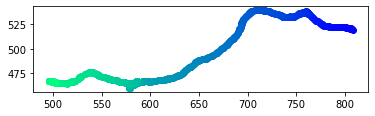

In [18]:
NPOINTS = len(locs)
start = 0
fig,ax = plt.subplots(1)

ax.set_prop_cycle('color',plt.cm.winter(np.linspace(0,1,NPOINTS)))
for i in np.arange(start,start+NPOINTS-1):
    img = ax.scatter(locs[i,0],locs[i,1])
    ax.set_aspect('equal','box')